In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image, display
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
titanic = pd.read_csv('https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv')

In [3]:
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
print("Shape:", titanic.shape)
print("Size:", titanic.size)

Shape: (891, 12)
Size: 10692


# Data Exploration

In [5]:
print("Null Error Rate:", format(titanic['Survived'].mean() * 100, '.2f'), '%')

Null Error Rate: 38.38 %


Overall chance of survival for a Titanic passenger is low.

In [6]:
titanic.groupby('Pclass').mean()

PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        461.597222  0.629630  38.233441  0.416667  0.356481  84.154687
2        445.956522  0.472826  29.877630  0.402174  0.380435  20.662183
3        439.154786  0.242363  25.140620  0.615071  0.393075  13.675550

Chances of survival are higher for 1st class passengers (63%) compared to those in 2nd class (47%) and 3rd class (24%).

In [7]:
class_sex_grouping = titanic.groupby(['Pclass','Sex']).mean()
class_sex_grouping

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

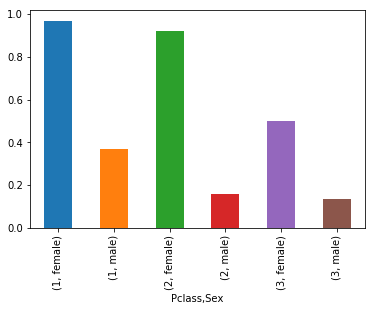

In [8]:
class_sex_grouping['Survived'].plot.bar()
plt.show()

In each passenger class, females have a higher chance of survival.

# Data Preparation

We use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch (Parents/children aboard), and Fare to predict whether a passenger survived.

In [9]:
titanic = titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]

In [10]:
titanic.isnull().any()

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Survived    False
dtype: bool

In [11]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
# Substitute NANs in age column

titanic["Age"].fillna(titanic["Age"].mean(),inplace=True)

Convert Categorical values to numerics

In [13]:
titanic.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [14]:
# Mapping Sex
titanic['Sex'] = titanic['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Build the model

In [25]:
# The columns that we will be making predictions with
X = titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

#The column that we will be making predictions on
y = titanic['Survived']

In [26]:
### Split data randomly into 70% training and 30% test ###

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
predicted = model2.predict(X_test)
print("Accuracy for test data set:\n")
print (format(metrics.accuracy_score(y_test, predicted) * 100,'.2f'), '%.')

Accuracy for test data set:

79.85 %.


Perform GridSerach on the parameters and use the best estimator for scoring on the valiation set.

In [35]:
param_test1 = {
 'max_depth': range(2, 5),   
 'min_samples_split': [2, 3, 5],
 'min_samples_leaf': [1, 2, 3]
}

grid_result = GridSearchCV(DecisionTreeClassifier(), param_grid=param_test1, cv=10, n_jobs=-1, verbose=1)
grid_result.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best: 0.820225 using {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    4.3s finished


In [37]:
print("Accuracy for test data set:\n")
predicted = grid_result.predict(X_test)
print (format(metrics.accuracy_score(y_test, predicted) * 100,'.2f'), '%.')

Accuracy for test data set:

82.46 %.


The model has now achieved 82.5% accuracy after optimizing decision hyper-parameters. Let's plot the tree.

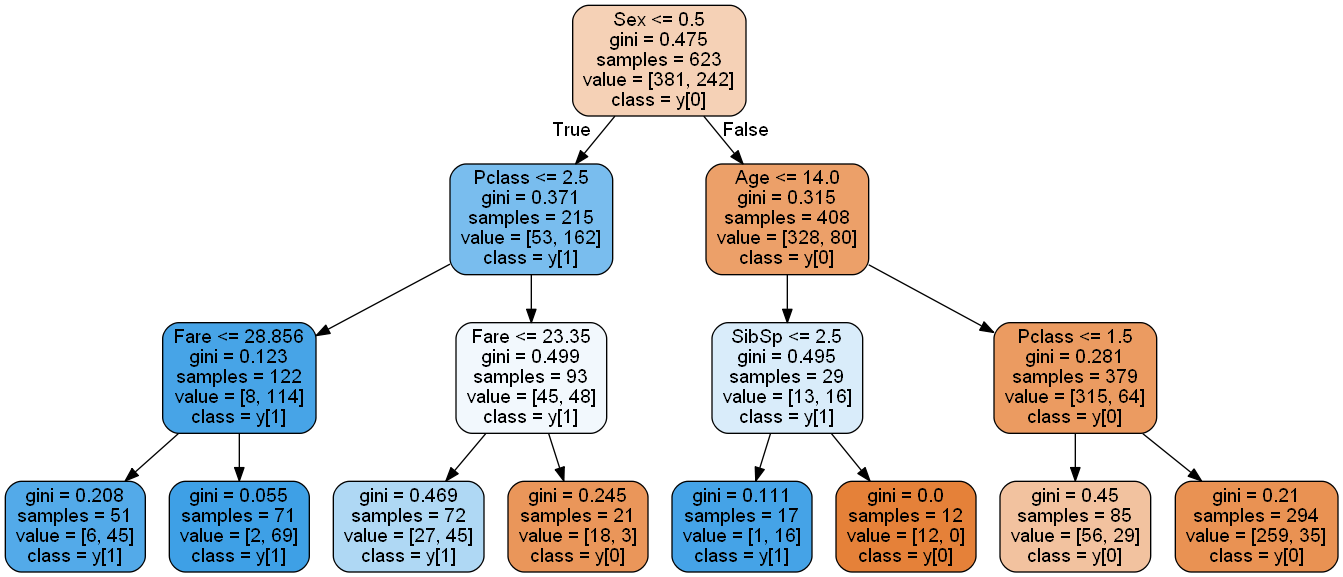

In [38]:
dot_data = tree.export_graphviz(grid_result.best_estimator_, out_file=None, filled=True, rounded=True,
                                feature_names=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'],
                                class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

Lets predict the chance of survival of a 3 year old boy travelling with parents in 2nd class.

In [41]:
grid_result.predict_proba(np.array([[2, 1, 3, 0, 2, 0.0]]))

array([[0.05882353, 0.94117647]])

The predicted probability of survival is 94%.